In [7]:
# Load in libraries
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import numpy as np
from torch.utils.data import DataLoader
from IPython.display import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
from sklearn.metrics import classification_report
%matplotlib inline

In [8]:
train = '/Users/jaxen1/Shared/C/Machine Learning/project2/Untitled/MachineLearningProject3/images/train'
razorback_transforms = transforms.Compose([
    transforms.Resize(128),              # resize shortest side to 128, keep aspect ratio
    transforms.CenterCrop([128, 128]),   # crop to square
    transforms.RandomHorizontalFlip(),
    #transforms.ToTensor()
])

dataset = ImageFolder(root=train, transform = razorback_transforms)
print('Train set:', len(dataset))


Train set: 60


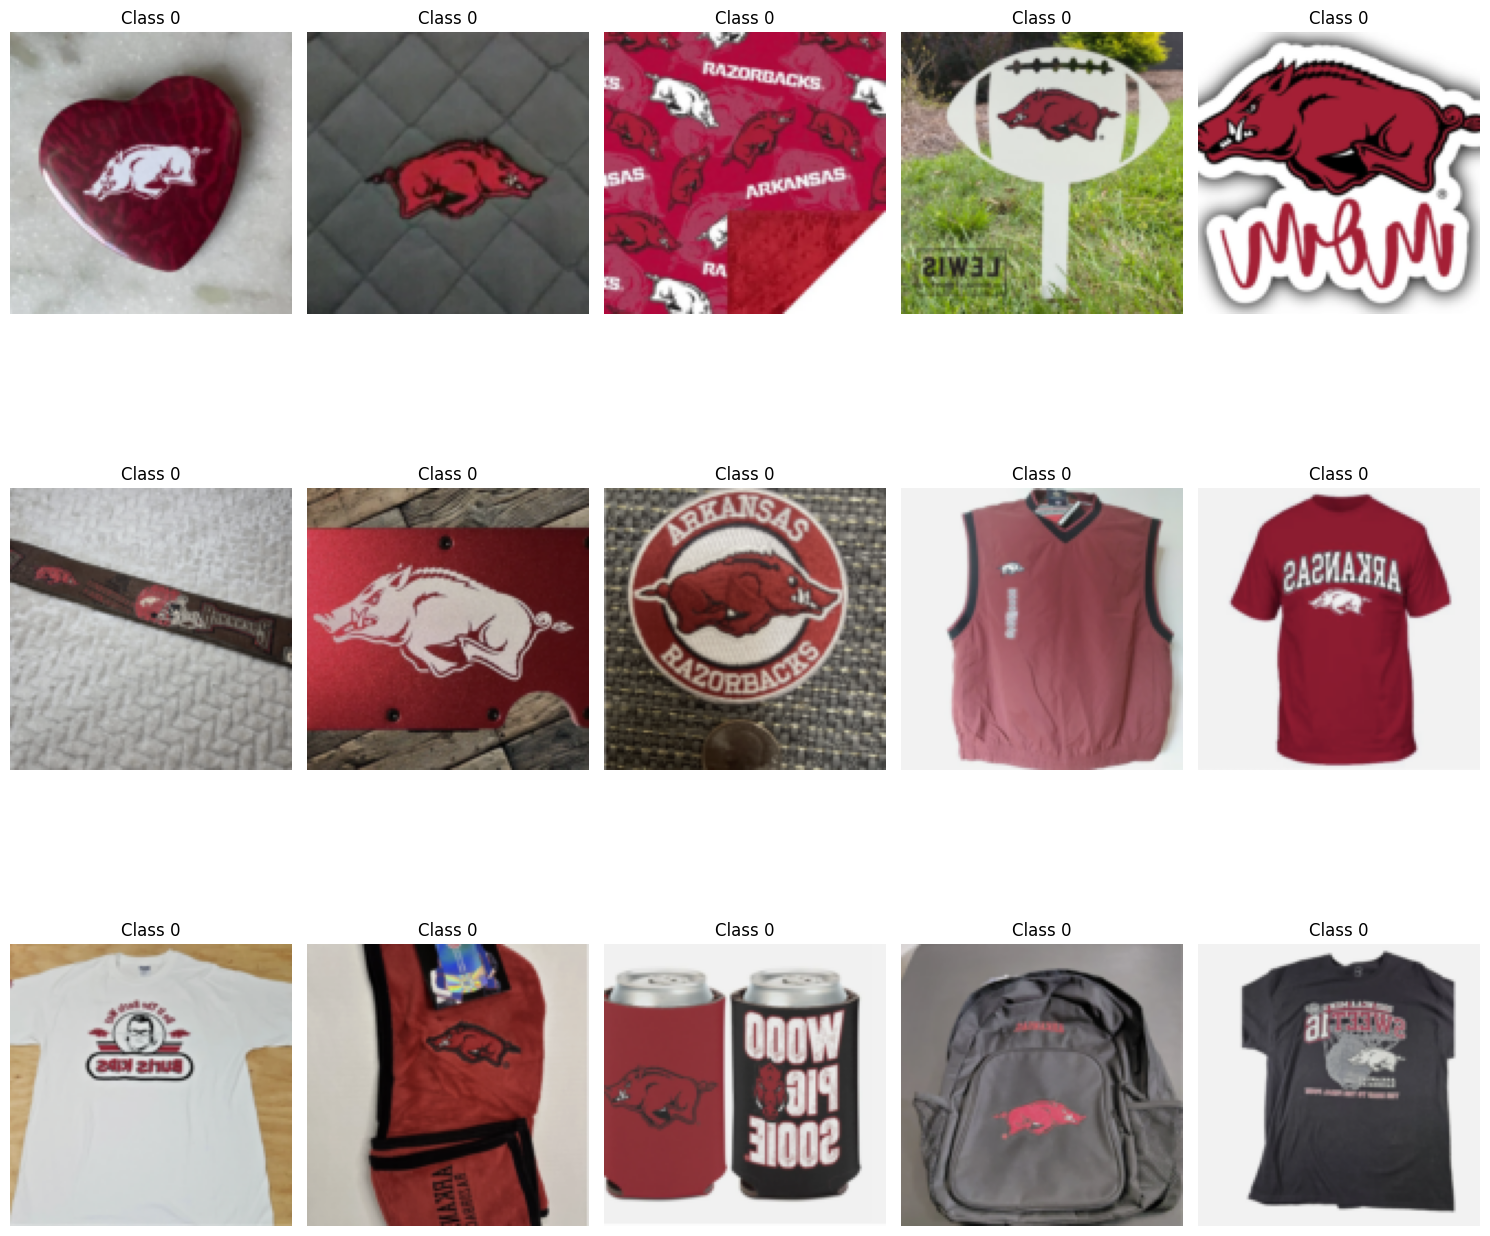

In [9]:
# Fix randomness for reproducibility
torch.manual_seed(17)

# Plot 15 images
fig = plt.figure(figsize=(15, 15))
for i in range(15):
    img, label = dataset[i]   # get image and label
    ax = fig.add_subplot(3, 5, i+1) # 3 rows × 5 columns grid
    ax.imshow(img)                  # show the PIL image
    ax.axis("off")
    ax.set_title(f"Class {label}")

plt.tight_layout()
plt.show()


In [10]:
transformsToTensor = transforms.Compose([
    transforms.Resize(128),              # resize shortest side to 128, keep aspect ratio
    transforms.CenterCrop([128, 128]),   # crop to square
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop([128, 128]),
    transforms.ToTensor()
])


dataset = ImageFolder(root=train, transform = transformsToTensor)
print('Train set:', len(dataset))

Train set: 60


In [11]:
# box 5
# Create data loa
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
torch.manual_seed(17)



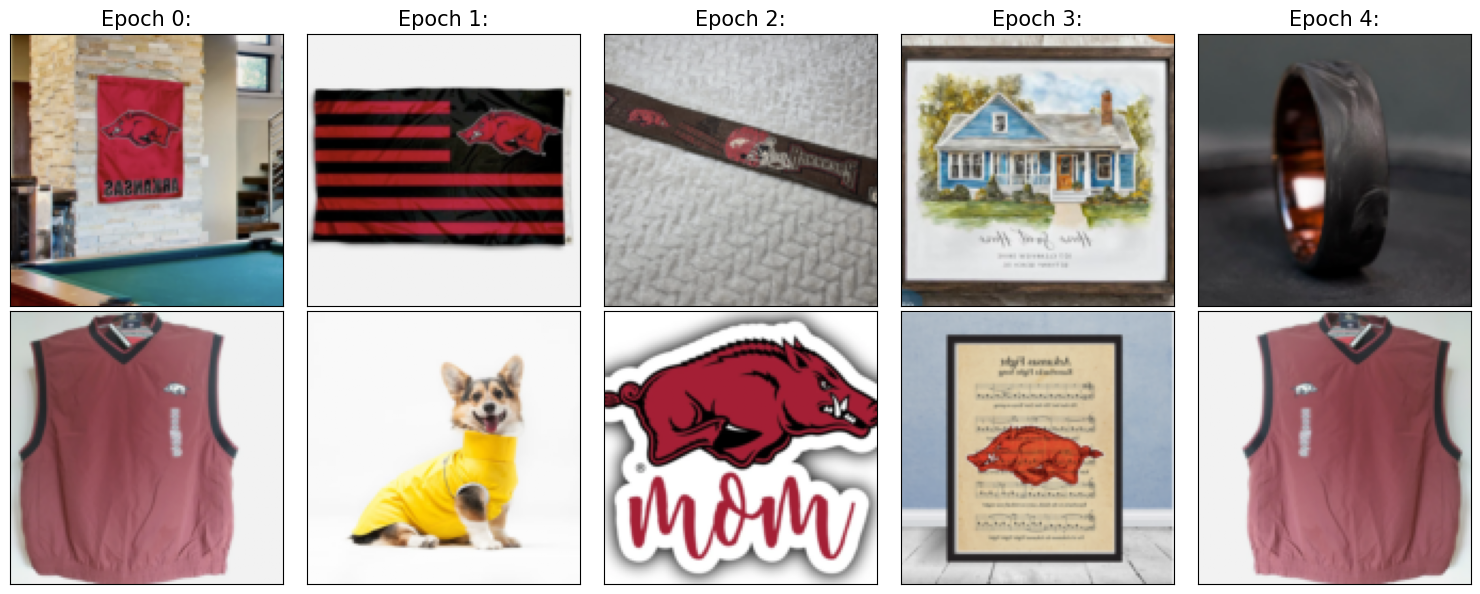

In [12]:
# Visalize how data is samplesd in different epochs
fig = plt.figure(figsize=(15, 6))

num_epochs = 5
for j in range(num_epochs):
    img_batch, label_batch = next(iter(train_loader))
    img = img_batch[0]
    ax = fig.add_subplot(2, 5, j + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Epoch {j}:', size=15)
    ax.imshow(img.permute(1, 2, 0))

    img = img_batch[1]
    ax = fig.add_subplot(2, 5, j + 6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img.permute(1, 2, 0))

plt.tight_layout()
plt.show()

In [13]:
# Create the training and test split

train_size = int(0.75 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply the test transforms to the test dataset
val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

In [14]:
val_size

6

In [15]:
# box 10 explain what this does overall and what it creates
model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout1', nn.Dropout(p=0.5))

model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout2', nn.Dropout(p=0.5))

model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))

model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module('relu4', nn.ReLU())

In [16]:
# box 11 explain overall and why we did this

x = torch.ones((4, 3, 64, 64))
model(x).shape

torch.Size([4, 256, 8, 8])

In [17]:
# box 12
# what does this do. Can we exclude? Hint:  look at chapter
model.add_module('pool4', nn.AvgPool2d(kernel_size=8))

# what does this do
model.add_module('flatten', nn.Flatten())

# what does this do..does it provide expected size
x = torch.ones((4, 3, 64, 64))
model(x).shape

torch.Size([4, 256])

In [18]:
# box 13
# what does this do
model.add_module('fc', nn.Linear(1024, 1))

# what does this do
model.add_module('sigmoid', nn.Sigmoid())

In [19]:
# box 16
# what does this do
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# what does this do
model = model.to(device)

In [20]:
# box 17
# what does this do
loss_fn = nn.BCELoss()

In [21]:
# box 18
# explain overall
def train(model, num_epochs, train_dl, valid_dl, optimizer):

    # explain this group
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    # what does this do
    for epoch in range(num_epochs):

        # what does this do
        model.train()

        # what does this do
        for x_batch, y_batch in train_dl:
            # what does this do
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # what does this do
            pred = model(x_batch)[:, 0]

            # what does this do
            loss = loss_fn(pred, y_batch.float())

            # what does this do
            loss.backward()

            # what does this do
            optimizer.step()

            # what does this do
            optimizer.zero_grad()

            # what does this group do
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        # what does this group do
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        # what does this do
        model.eval()

        # what does this do
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')

    # what does this function returns (do not just state the variables...describe what they represent like in a docustring)
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid


In [51]:
import copy
import random
seed = 17
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

model1 = copy.deepcopy(model)
model2 = copy.deepcopy(model) 
model3 = copy.deepcopy(model)

histb8 = train(model1, num_epochs=30,
     train_dl=DataLoader(train_dataset, batch_size=30, shuffle=True),
     valid_dl=DataLoader(val_dataset, batch_size=8),
     optimizer=torch.optim.Adam(model1.parameters(), lr=0.001))  

histb16 = train(model2, num_epochs=30,
     train_dl=DataLoader(train_dataset, batch_size = 30, shuffle=True),
     valid_dl=DataLoader(val_dataset, batch_size=16),
     optimizer=torch.optim.Adam(model2.parameters(), lr=0.001))  # model3!

histb32 = train(model3, num_epochs=30,
     train_dl=DataLoader(train_dataset, batch_size=30, shuffle=True),
     valid_dl=DataLoader(val_dataset, batch_size=32),
     optimizer=torch.optim.Adam(model3.parameters(), lr=0.001))  # model5!

Epoch 1 accuracy: 0.4444 val_accuracy: 0.1667
Epoch 2 accuracy: 0.5333 val_accuracy: 0.1667
Epoch 3 accuracy: 0.4889 val_accuracy: 0.8333
Epoch 4 accuracy: 0.4667 val_accuracy: 0.3333
Epoch 5 accuracy: 0.5111 val_accuracy: 0.1667
Epoch 6 accuracy: 0.5556 val_accuracy: 0.1667
Epoch 7 accuracy: 0.6444 val_accuracy: 0.1667
Epoch 8 accuracy: 0.6000 val_accuracy: 0.1667
Epoch 9 accuracy: 0.5333 val_accuracy: 0.1667
Epoch 10 accuracy: 0.5333 val_accuracy: 0.1667
Epoch 11 accuracy: 0.5333 val_accuracy: 0.1667
Epoch 12 accuracy: 0.5333 val_accuracy: 0.1667
Epoch 13 accuracy: 0.5333 val_accuracy: 0.1667
Epoch 14 accuracy: 0.5333 val_accuracy: 0.1667
Epoch 15 accuracy: 0.5333 val_accuracy: 0.1667
Epoch 16 accuracy: 0.5333 val_accuracy: 0.1667
Epoch 17 accuracy: 0.5333 val_accuracy: 0.1667
Epoch 18 accuracy: 0.6000 val_accuracy: 0.3333
Epoch 19 accuracy: 0.6444 val_accuracy: 0.5000
Epoch 20 accuracy: 0.6444 val_accuracy: 0.3333
Epoch 21 accuracy: 0.5556 val_accuracy: 0.3333
Epoch 22 accuracy: 0.5

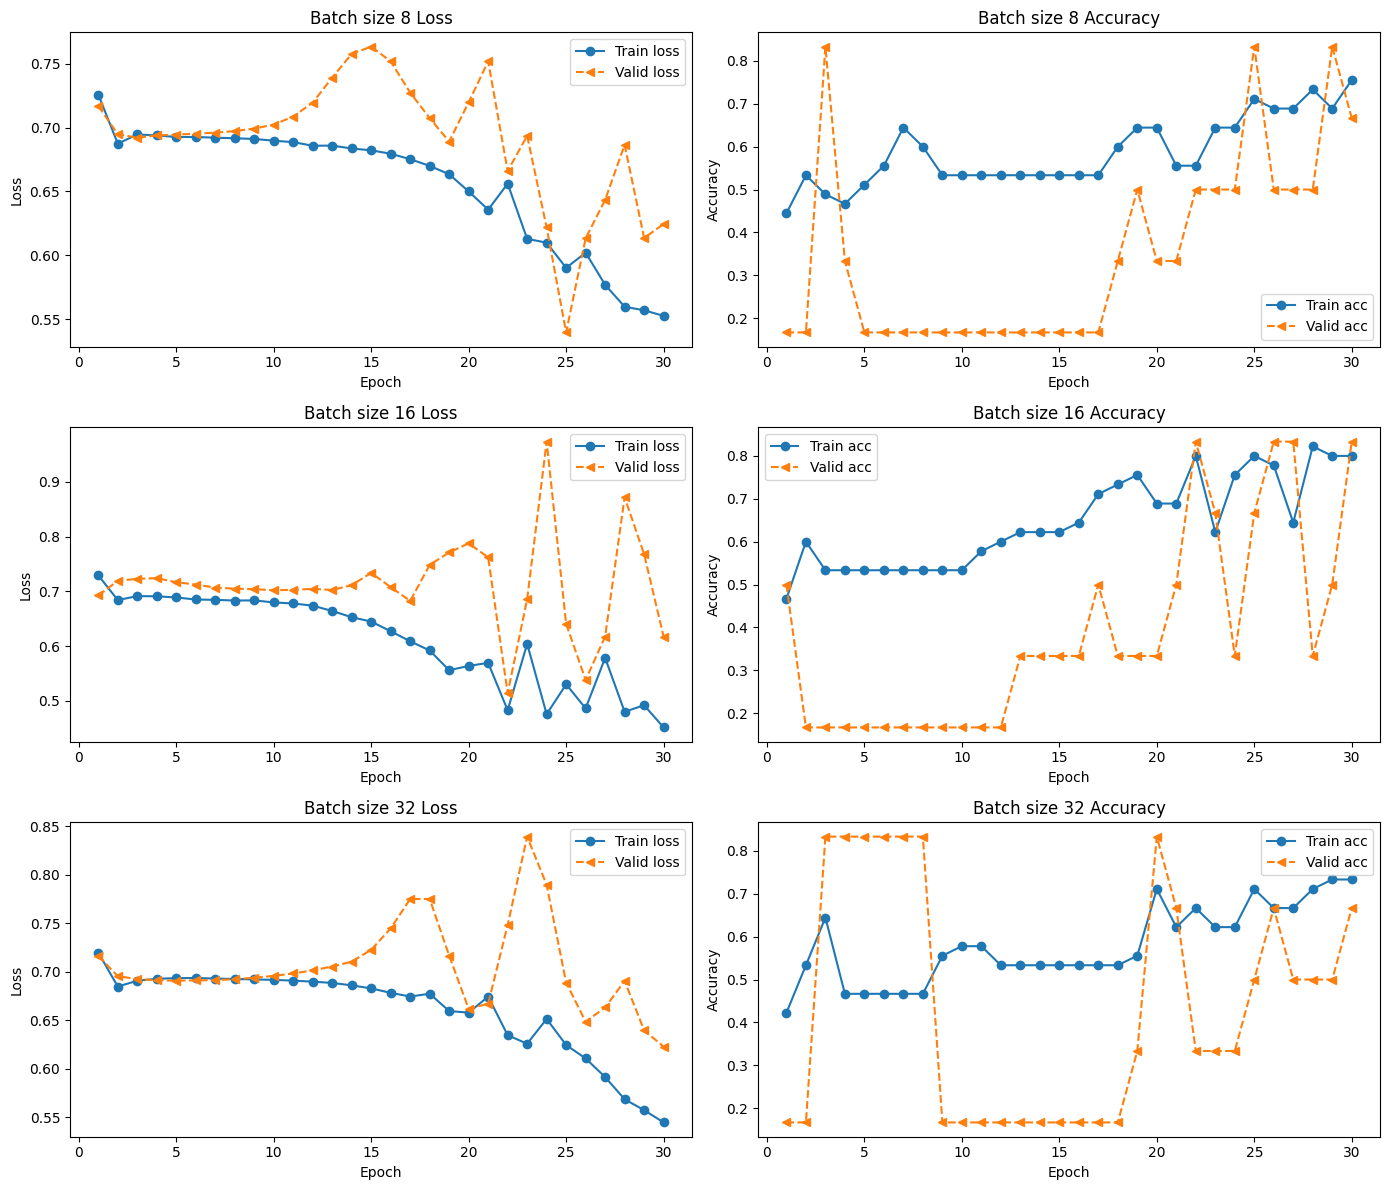

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Example: store all histories
all_runs = {
    "Batch size 8": histb8,
    "Batch size 16": histb16,
    "Batch size 32": histb32
    # add more runs here, e.g. "Batch size 16": histb16lr001
}

n_runs = len(all_runs)
fig, axes = plt.subplots(n_runs, 2, figsize=(14, 4 * n_runs))  # n_runs rows × 2 plots each

# If only one run, axes won't be 2D, so fix that
if n_runs == 1:
    axes = np.array([axes])

for i, (name, hist) in enumerate(all_runs.items()):
    # Convert tensor accuracies to floats
    train_acc = [a.item() for a in hist[2]]
    valid_acc = [a.item() for a in hist[3]]
    
    x_arr = np.arange(len(hist[0])) + 1
    
    # Loss plot
    axes[i, 0].plot(x_arr, hist[0], '-o', label='Train loss')
    axes[i, 0].plot(x_arr, hist[1], '--<', label='Valid loss')
    axes[i, 0].set_title(f"{name} Loss")
    axes[i, 0].set_xlabel("Epoch")
    axes[i, 0].set_ylabel("Loss")
    axes[i, 0].legend()
    
    # Accuracy plot
    axes[i, 1].plot(x_arr, train_acc, '-o', label='Train acc')
    axes[i, 1].plot(x_arr, valid_acc, '--<', label='Valid acc')
    axes[i, 1].set_title(f"{name} Accuracy")
    axes[i, 1].set_xlabel("Epoch")
    axes[i, 1].set_ylabel("Accuracy")
    axes[i, 1].legend()

plt.tight_layout()
plt.show()


In [65]:
# Look at test accuracy
accuracy_test = 0

# what does this do
model.eval()

# what does this do
y_true, y_pred = [], []
with torch.no_grad():
    for x_batch, y_batch in DataLoader(test_dataset, batch_size=4):
        x_batch = x_batch.to(device)
        y_batch = y_batch.cpu()
        pred = (model2(x_batch)[:,0].cpu() >= 0.5).int()
        y_true.extend(y_batch.numpy())
        y_pred.extend(pred.numpy())

accuracy_test /= len(DataLoader(test_dataset, batch_size=4).dataset)

print(classification_report(y_true, y_pred))

# Look at test accuracy
accuracy_test = 0

# what does this do
model.eval()

# what does this do
y_true, y_pred = [], []
with torch.no_grad():
    for x_batch, y_batch in DataLoader(val_dataset, batch_size=4):
        x_batch = x_batch.to(device)
        y_batch = y_batch.cpu()
        pred = (model2(x_batch)[:,0].cpu() >= 0.5).int()
        y_true.extend(y_batch.numpy())
        y_pred.extend(pred.numpy())

accuracy_test /= len(DataLoader(val_dataset, batch_size=4).dataset)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         4
           1       0.60      0.60      0.60         5

    accuracy                           0.56         9
   macro avg       0.55      0.55      0.55         9
weighted avg       0.56      0.56      0.56         9

              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.50      1.00      0.67         1

    accuracy                           0.83         6
   macro avg       0.75      0.90      0.78         6
weighted avg       0.92      0.83      0.85         6



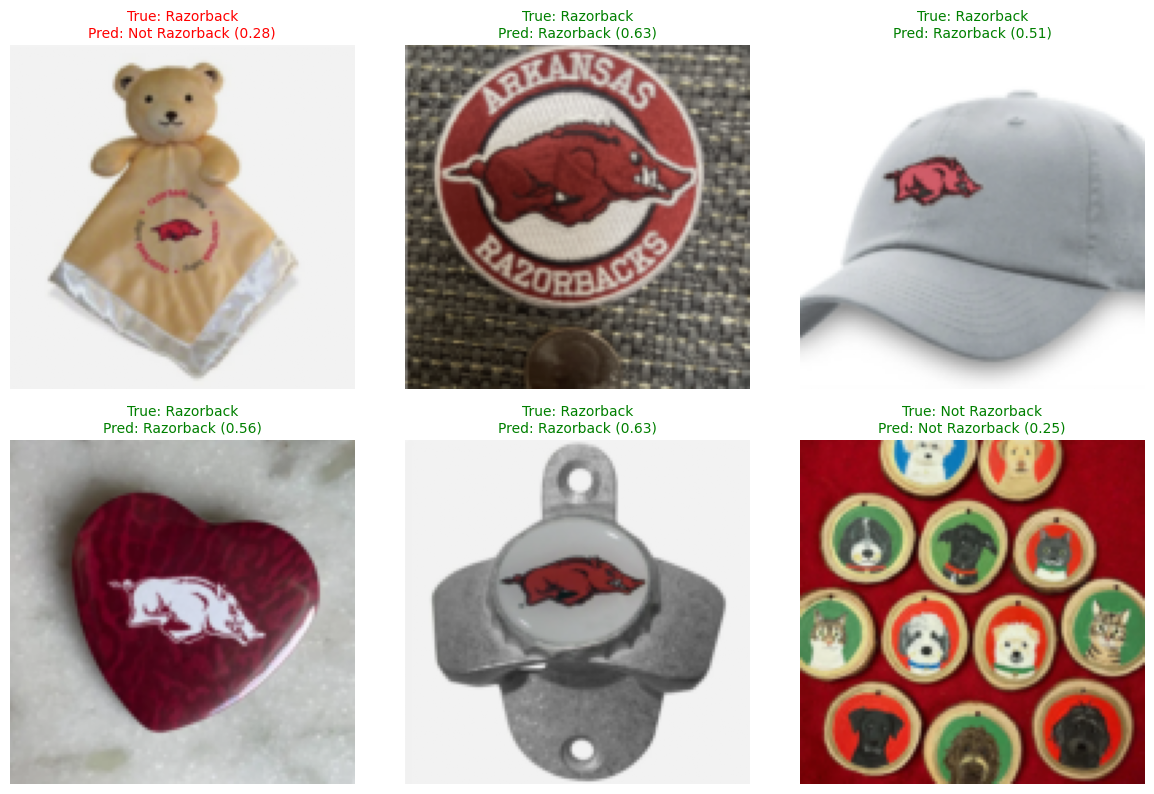

In [59]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Move model to eval mode
model.eval()

# Get all test predictions and labels
all_preds = []
all_probs = []
all_labels = []
all_images = []

with torch.no_grad():
    for x_batch, y_batch in DataLoader(val_dataset, batch_size=4):
        x_batch = x_batch.to(device)
        y_batch_cpu = y_batch.cpu()
        probs = model2(x_batch)[:, 0].cpu()  # output probabilities since your model already has Sigmoid
        preds = (probs >= 0.5).int()        # threshold to get 0/1 prediction

        all_preds.extend(preds.numpy())
        all_probs.extend(probs.numpy())
        all_labels.extend(y_batch_cpu.numpy())
        all_images.extend(x_batch.cpu())    # store images for visualization

all_preds = np.array(all_preds)
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)
all_images = torch.stack(all_images)

# --- Visualize the first 16 images with predictions ---
num_images = min(16, len(all_images))
plt.figure(figsize=(12, 12))

for i in range(num_images):
    plt.subplot(3, 3, i+1)
    img = all_images[i].permute(1, 2, 0)  # CHW -> HWC
    plt.imshow(img)
    
    true_label = "Not Razorback" if all_labels[i] == 1 else "Razorback"
    pred_label = "Not Razorback" if all_preds[i] == 1 else "Razorback"
    prob = all_probs[i]
    
    color = "green" if all_labels[i] == all_preds[i] else "red"  # correct in green, wrong in red
    plt.title(f"True: {true_label}\nPred: {pred_label} ({1-prob:.2f})", color=color, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [62]:
import os

# what does this do
if not os.path.exists('models'):
    os.mkdir('models')

path = 'models/razorback-cnn.ph'

# what does this do
torch.save(model, path)

In [63]:
# what does this do
loaded_full_model = torch.load(path, weights_only=False)

# what does this do
loaded_full_model.eval()

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=1024, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)